# Problem Statement

What is the best features for you to maximize the price of your house?

To predict the price patterns of the houses in the area:

1) I am going to find the neccessary data relating to the area.

2) Clean the data

3) Perform EDA on the clean data

4) Decide on which variables are good predictors to use in the models

5) Create a model based on selected variables

6) Test how good the models are in predicting house prices

7) Use the best Model

8) Recommendations for housing price

# Quick Guide

#### - [1. Import Train Data](#Import)

#### - [2. Data Cleaning](#Data_Cleaning)

   - [Identify all columns with Null Values](#allnull)
   - [Indentify Variables with huge Null Values](#hugenull)
   - [Check for Outliers](#checkoutliers)
   - [Check Remaining Null Values](#checknull)
        - [Split into Catergorical and Continuous variables](#splitter)
   - [Fill Null Values in Main Table](#fillnull)

#### - [3. Spliting Dataframe](#Split_dataframe)

   - [Split into Catergorical and Continuous Variable](#splitcc)
   - [Split Catergorical into Ordinal and Nominal](#splitdf)
   - [Rank Ordinal Variables / Drop any unusable columns in train_ord](#rankord)

### [Model 1](#Model1)

#### - [4. Check for Correlation](#check__corr)

   - [Check for Correlation between Price and Variables](#check_corr)
   - [Check Boxplot Between Price and Variables](#boxplot)
   
#### - [5. Create Model](#create_model)

   - [Determine which Column to drop](#drop)
   - [Merge DataFrames to create Model](#merge)
   - [Check for correlation and pick 30 highest correlation](#corr)
   
#### - [6. Prep Model](#model_prep)

#### - [7. Test Model](#test1)

   - [Check for Multicollinearity](#multicollienearity1)
   
#### - [8. Refine Model](#refine1)

### [Model 2](#model2)
   - [Merge DataFrames (Cont / Ord / Nom)](#merge2)
   - [Using LassoCV to remove unneccessary Variables](#lasso)
   - [Create Model](#model_prep2)
   - [Check for Multicollinearity](#multicollinearity2)
   - [Test Model](#test2)
   
### [Model 3](#model3)
   - [Merge DataFrames](#merge3)
   - [Feature Engineering](#feature_eng)
   - [Create our features matrix (`X`) and target vector (`y`)](#create_xy3)
   - [Check for Multicollinearity](#multicollinearity3)
   - [Model Prep](#model_prep3)
   - [Test Model](#test3)
   
#### - [9. Test Model on Kaggle Test Data](#Kaggle)
   - [Predict Kaggle Data with Model 1](#kaggle_1)
   - [Predict Kaggle Data with Model 2](#kaggle_2)
   - [Predict Kaggle Data with Model 3](#kaggle_3)

#### - [10. Recommendations](#Recommendations)

# Import Libraries

In [1]:
# Importing libraries
import pandas as pd
import pandas_profiling
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [2]:
# Prevent warnings from appearing
warnings.filterwarnings('ignore')

# Functions Used

In [3]:
# Function for Categorical Plots
# Scatter types [strip, swarm]
# Dist types [box, violin, boxen]
# Estimate types [point, bar, count]
def catplot(data_, figuresize, plot):
    plt.figure(figsize=figuresize) # Figure size for all plots

    for i in range(len(data_.columns)):
        if len(data_.columns) // 2 == 0:
            ax = plt.subplot(len(data_.columns)/2, 2, i+1) # plt.subplot(no. of rows, no of plot per row, choose the plot(i=0))
        else:
            ax = plt.subplot((len(data_.columns)+1)/2, 2, i+1)
                             
        plt.setp(ax, xticks =(), yticks = ()) # Setup the axis
        plt.title(label = "{} vs SalePrice".format(data_.columns[i])) # Set Title

        sns.catplot(y = 'saleprice', x = data_.columns[i],data=data_, kind = plot)

In [4]:
# Function to plot Boxplots
def boxplot(data, figuresize, sale):
    plt.figure(figsize=figuresize) # Figure size for all plots

    for i in range(len(data.columns)):
        if len(data.columns) // 2 == 0:
            ax = plt.subplot(len(data.columns)/2, 2, i+1) # plt.subplot(no. of rows, no of plot per row, choose the plot(i=0))
        else:
            ax = plt.subplot((len(data.columns)+1)/2, 2, i+1)
                             
        plt.setp(ax, xticks =(), yticks = ()) # Setup the axis
        plt.title(label = "{} vs SalePrice".format(data.columns[i])) # Set Title

        sns.boxplot(y = data[sale], x = data[data.columns[i]] )

In [5]:
# Function to plot regplot
def regplot(data, figuresize, sale):
    plt.figure(figsize=figuresize) # Figure size for all plots

    for i in range(len(data.columns)):
        if len(data.columns) // 2 == 0:
            ax = plt.subplot(len(data.columns)/2, 2, i+1) # plt.subplot(no. of rows, no of plot per row, choose the plot(i=0))
        else:
            ax = plt.subplot((len(data.columns)+1)/2, 2, i+1)
                             
        plt.setp(ax, xticks =(), yticks = ()) # Setup the axis
        plt.title(label = "{} vs SalePrice".format(data.columns[i])) # Set Title

        sns.regplot(y = data[sale], x = data[data.columns[i]] )

In [6]:
# Function to plot Distribution Plot
def distplot(data, figuresize):
    plt.figure(figsize=figuresize) # Figure size for all plots

    for i in range(len(data.columns)):
        if len(data.columns) // 2 == 0:
            ax = plt.subplot(len(data.columns)/2, 2, i+1) # plt.subplot(no. of rows, no of plot per row, choose the plot(i=0))
        else:
            ax = plt.subplot((len(data.columns)+1)/2, 2, i+1)
                             
        plt.setp(ax, xticks =(), yticks = ()) # Setup the axis
        plt.title(label = "{} vs SalePrice".format(data.columns[i])) # Set Title

        sns.distplot(data[data.columns[i]])

In [7]:
# Function to plot Heatmap
def heatmap(data, figuresize):
    plt.figure(figsize=figuresize)
    plt.title("Correlation Heatmap")
    sns.heatmap(data.corr(), vmin= -1, annot=True)


In [8]:
# Function to fill up all the Null Values
def fill_null(data, columns):
    for i in columns:
        if i == "Lot Frontage":
            data[i] = data[i]
        elif data[i].dtypes == object:
            data[i].fillna("NA", inplace=True)
        else:
            data[i].fillna(0, inplace=True)

In [9]:
# Function to identify Multicollinearity
def multicollinearity(model):
    for i in model.columns:
        for j in model.columns:
            if i != j:
                corr = model[i].corr(model[j])
                if corr > 0.7:
                    print('{} and {} corr = {}'.format(i,j,corr))

In [10]:
# Function to create Basic Data Dictionary
def data_dictionary(data):
    for i in data:
        print("|" + str(i) + '|' + str(data[i].dtypes) + '|' + "train" + '| |')

In [11]:
# Function to rename Columns
def rename(x):
    if x == x.lower():
        return x
    else:
        try:
            x = x.replace(" ", "_").lower()
            return x
        except:
            return x

<a id='Import'></a>
# 1) Import Train Data

In [12]:
train = pd.read_csv('../datasets/train.csv', dtype={'MS SubClass': object, "PID": object, "Overall Qual": object, "Overall Cond": object})

In [13]:
train.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


### Looking for errors

In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
Id                 2051 non-null int64
PID                2051 non-null object
MS SubClass        2051 non-null object
MS Zoning          2051 non-null object
Lot Frontage       1721 non-null float64
Lot Area           2051 non-null int64
Street             2051 non-null object
Alley              140 non-null object
Lot Shape          2051 non-null object
Land Contour       2051 non-null object
Utilities          2051 non-null object
Lot Config         2051 non-null object
Land Slope         2051 non-null object
Neighborhood       2051 non-null object
Condition 1        2051 non-null object
Condition 2        2051 non-null object
Bldg Type          2051 non-null object
House Style        2051 non-null object
Overall Qual       2051 non-null object
Overall Cond       2051 non-null object
Year Built         2051 non-null int64
Year Remod/Add     2051 non-null int64
Roof Style       

In [15]:
train.describe()

,Id,Lot Frontage,Lot Area,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,...,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice
count,2051.000000,1721.000000,2051.000000,2051.000000,2051.000000,2029.000000,2050.000000,2050.000000,2050.000000,2050.000000,...,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000
mean,1474.033642,69.055200,10065.208191,1971.708922,1984.190151,99.695909,442.300488,47.959024,567.728293,1057.987805,...,93.833740,47.556802,22.571916,2.591419,16.511458,2.397855,51.574354,6.219893,2007.775719,181469.701609
std,843.980841,23.260653,6742.488909,30.177889,21.036250,174.963129,461.204124,165.000901,444.954786,449.410704,...,128.549416,66.747241,59.845110,25.229615,57.374204,37.782570,573.393985,2.744736,1.312014,79258.659352
min,1.000000,21.000000,1300.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,12789.000000
25%,753.500000,58.000000,7500.000000,1953.500000,1964.500000,0.000000,0.000000,0.000000,220.000000,793.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129825.000000
50%,1486.000000,68.000000,9430.000000,1974.000000,1993.000000,0.000000,368.000000,0.000000,474.500000,994.500000,...,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,162500.000000
75%,2198.000000,80.000000,11513.500000,2001.000000,2004.000000,161.000000,733.750000,0.000000,811.000000,1318.750000,...,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,2930.000000,313.000000,159000.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,...,1424.000000,547.000000,432.000000,508.000000,490.000000,800.000000,17000.000000,12.000000,2010.000000,611657.000000


<a id='Data_Cleaning'></a>
# 2) Data Cleaning

<a id='allnull'></a>
### 2.1) Identify all columns with Null Values

In [16]:
train.isnull().sum().sort_values(ascending = False).head(26)

Pool QC           2042
Misc Feature      1986
Alley             1911
Fence             1651
Fireplace Qu      1000
Lot Frontage       330
Garage Finish      114
Garage Cond        114
Garage Qual        114
Garage Yr Blt      114
Garage Type        113
Bsmt Exposure       58
BsmtFin Type 2      56
BsmtFin Type 1      55
Bsmt Cond           55
Bsmt Qual           55
Mas Vnr Type        22
Mas Vnr Area        22
Bsmt Half Bath       2
Bsmt Full Bath       2
Garage Cars          1
Garage Area          1
Bsmt Unf SF          1
BsmtFin SF 2         1
Total Bsmt SF        1
BsmtFin SF 1         1
dtype: int64

<h1><center>Null Values Data Dictionary</center></h1>

|Feature|Type|Number of Null|Description|
|---|---|---|---|
|Pool QC|Object|2042| Null Value should be NA(Ordinal)|
|Misc Feature|Object|1986| Null Value should be NA(Ordinal)|
|Alley|Object|1911|Null Value should be NA(Nominal)|
|Fence|Object|1651|Null Value should be NA(Ordinal)|
|Fireplace Qu|Object|1000|Null Value should be NA(Ordinal)|
|Lot Frontage|Int|330|Null Value should be Null/0(Continous)|
|Garage Finish|Object|114|Null Value should be NA(Ordinal)|
|Garage Cond|Object|114|Null Value should be NA(Ordinal)|
|Garage Qual|Object|114|Null Value should be NA(Ordinal)|
|Garage Yr Blt|Int|114| Null Value remain Null(Discete)|
|Garage Type|Object|113|Null Value should be NA(Nomaial)|
|Bsmt Exposure|Object|58|Null Values should be NA(Ordinal)|
|BsmtFin Type 2|Object|56|Null Values should be NA(Ordinal)|
|BsmtFin Type 1|Object|55|Null Values should be NA(Ordinal)|
|Bsmt Cond|Object|55|Null Values should be NA(Ordinal)|
|Bsmt Qual|Object|55|Null Values should be NA(Ordinal)|
|Mas Vnr Type|Object|22|Null Values should be None(Nominal)|
|Mas Vnr Area|Int|22|Null Values should be 0(Continuous)|
|Bsmt Half Bath|Int|2|Null Values should be 0(Discrete)|
|Bsmt Full Bath|Int|2|Null Values should be 0(Discrete)|
|Garage Cars|Int|1|Null Values should be 0(Discrete)|
|Garage Area|Int|1|Null Values should be 0(Continous)|  
|Bsmt Unf SF|Int|1|Null Values should be 0(Continous)|
|BsmtFin SF 2|Int|1|Null Values should be 0|
|Total Bsmt SF|Int|1|Null Values should be 0|
|BsmtFin SF 1|Int|1|Null Values should be 0|

<a id='hugenull'></a>
### 2.2) Indentify Variables with huge Null Values 

In [17]:
# Create DataFrame with variables with too many null values with sale price
train_null = train[['SalePrice', 'Misc Feature', 'Fence', 'Pool QC', 'Alley']]
train_null.head()

,SalePrice,Misc Feature,Fence,Pool QC,Alley
0,130500,NaN,NaN,NaN,NaN
1,220000,NaN,NaN,NaN,NaN
2,109000,NaN,NaN,NaN,NaN
3,174000,NaN,NaN,NaN,NaN
4,138500,NaN,NaN,NaN,NaN


In [18]:
train_null = train_null.fillna("NA")

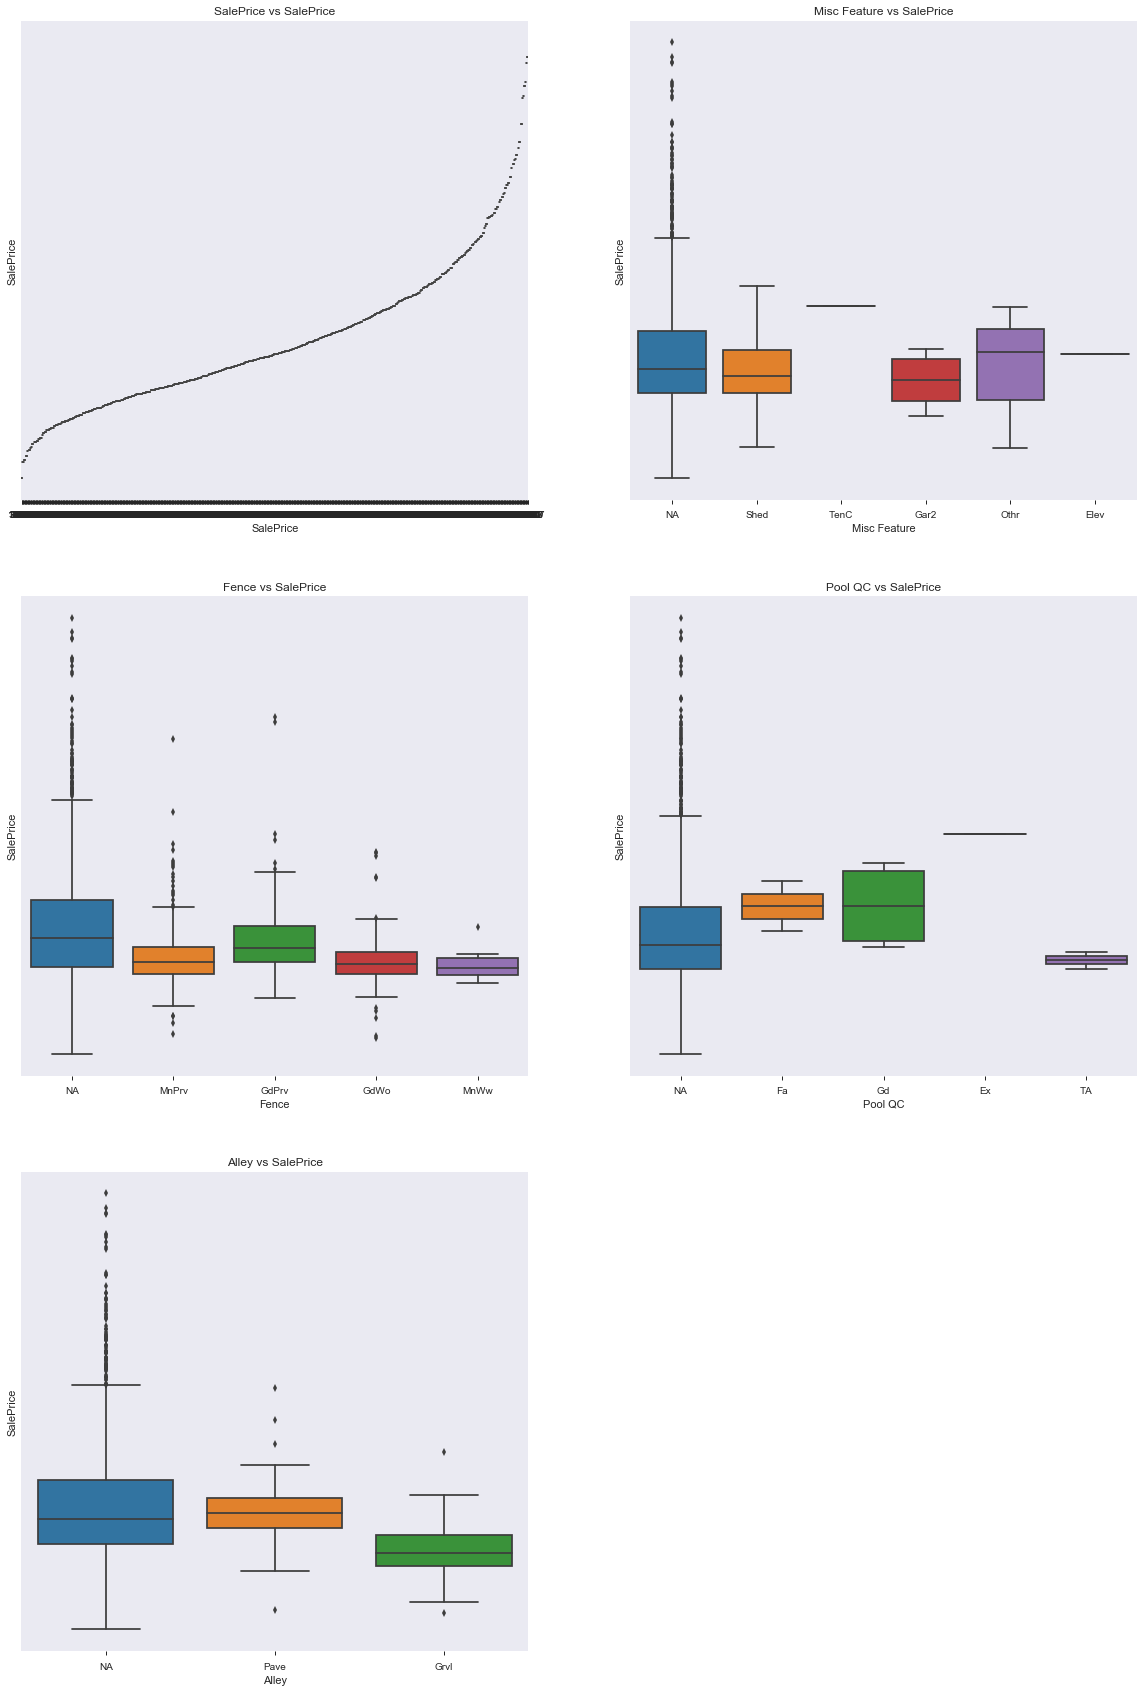

In [19]:
# Boxplot to see if categories have relationship with Saleprice
boxplot(train_null, (20,30), sale = 'SalePrice')

From the Barplots. It would seem that the columns there might have been some correlation with the Saleprice. However, there are too many null values, when they are changed to the NA category, the correlation is gone. Hence, these columns are not usable to predict SalePrice and shall be dropped.

In [20]:
# Change columns to get_dummies
train_null_dummies = pd.get_dummies(train_null)
train_null_dummies.head()

,SalePrice,Misc Feature_Elev,Misc Feature_Gar2,Misc Feature_NA,Misc Feature_Othr,Misc Feature_Shed,Misc Feature_TenC,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_NA,Pool QC_Ex,Pool QC_Fa,Pool QC_Gd,Pool QC_NA,Pool QC_TA,Alley_Grvl,Alley_NA,Alley_Pave
0,130500,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0
1,220000,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0
2,109000,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0
3,174000,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0
4,138500,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0


Text(0.5, 1.0, 'Heatmap for Categorical Null Variables')

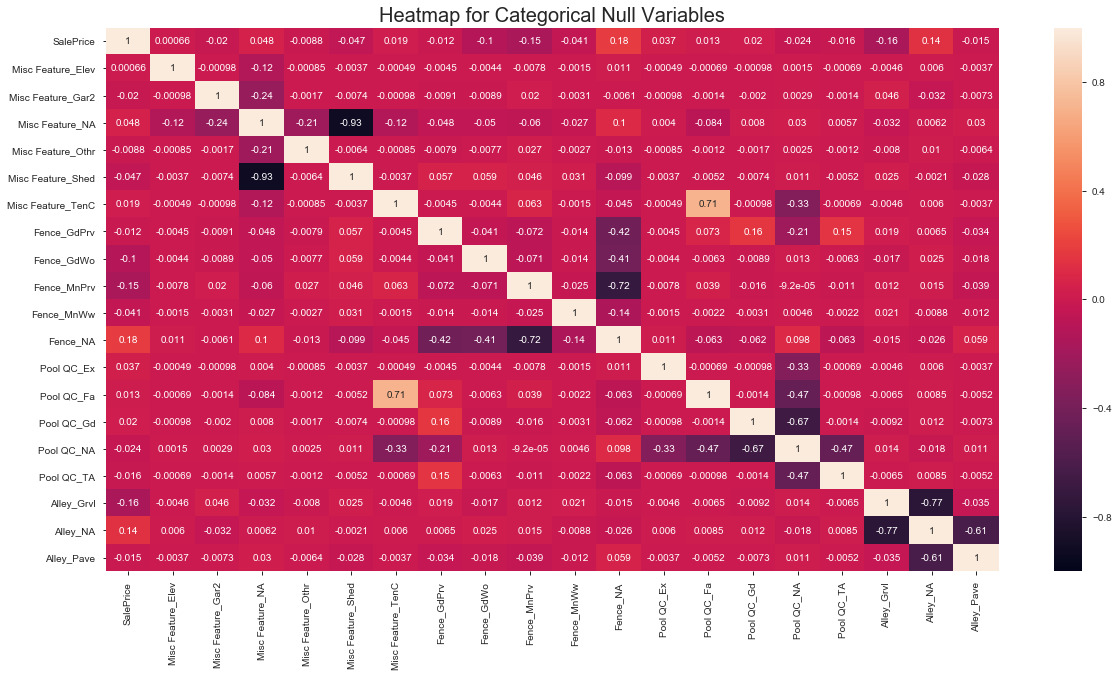

In [21]:
# Check if null Values are correlated with price
heatmap(train_null_dummies, figuresize = (20,10))
plt.title('Heatmap for Categorical Null Variables', fontsize = 20)

Based on the Heatmap, there is very little correlation between the dummy variables to SalePrice. Hence we shall drop all the columns.

In [22]:
# Drop Misc Feature, Fence, Pool QC, Alley for having too many null values and are not correlated with sales price
train = train.drop( axis = 1, columns = train[['Misc Feature', 'Fence', 'Pool QC', 'Alley']])

In [23]:
# Rename Columns
train = train.rename(columns = lambda x : rename(x))

<h1><center>Data Dictionary of Aimes_Iowa_Housing Dataset</center></h1>

|Feature|Type|Dataset|Description|
|---|---|---|---|
|id|int64|train|Observation number|
|pid|object|train|Parcel identification number  - can be used with city web site for parcel review|
|ms_subclass|object|train|Identifies the type of dwelling involved in the sale|
|ms_zoning|object|train|Identifies the general zoning classification of the sale|
|lot_frontage|float64|train|Linear feet of street connected to property|
|lot_area|int64|train|Lot size in square feet|
|street|object|train|Type of road access to property|
|lot_shape|object|train|General shape of property|
|land_contour|object|train|Flatness of the property|
|utilities|object|train|Type of utilities available|
|lot_config|object|train|Lot configuration|
|land_slope|object|train|Slope of property|
|neighborhood|object|train|Physical locations within Ames city limits|
|condition_1|object|train|Proximity to various conditions|
|condition_2|object|train|Proximity to various conditions (if more than one is present)|
|bldg_type|object|train|Type of dwelling|
|house_style|object|train|Style of dwelling|
|overall_qual|object|train|Rates the overall material and finish of the house|
|overall_cond|object|train|Rates the overall condition of the house|
|year_built|int64|train|Original construction date|
|year_remod/add|int64|train|Remodel date (same as construction date if no remodeling or additions)|
|roof_style|object|train|Type of roof|
|roof_matl|object|train|Roof material|
|exterior_1st|object|train|Exterior covering on house|
|exterior_2nd|object|train|Exterior covering on house (if more than one material)|
|mas_vnr_type|object|train|Masonry veneer type|
|mas_vnr_area|float64|train|Masonry veneer area in square feet|
|exter_qual|object|train|Evaluates the quality of the material on the exterior|
|exter_cond|object|train|Evaluates the present condition of the material on the exterior|
|foundation|object|train|Type of foundation|
|bsmt_qual|object|train|Evaluates the height of the basement|
|bsmt_cond|object|train|Evaluates the general condition of the basement|
|bsmt_exposure|object|train|Refers to walkout or garden level walls|
|bsmtfin_type_1|object|train|Rating of basement finished area|
|bsmtfin_sf_1|float64|train|Type 1 finished square feet|
|bsmtfin_type_2|object|train|Rating of basement finished area (if multiple types)|
|bsmtfin_sf_2|float64|train|Type 2 finished square feet|
|bsmt_unf_sf|float64|train|Unfinished square feet of basement area|
|total_bsmt_sf|float64|train|Total square feet of basement area|
|heating|object|train|Type of heating|
|heating_qc|object|train|Heating quality and condition|
|central_air|object|train|Central air conditioning|
|electrical|object|train|Electrical system|
|1st_flr_sf|int64|train|First Floor square feet|
|2nd_flr_sf|int64|train|Second floor square feet|
|low_qual_fin_sf|int64|train|Low quality finished square feet (all floors)|
|gr_liv_area|int64|train|Above grade (ground) living area square feet|
|bsmt_full_bath|float64|train|Basement full bathrooms|
|bsmt_half_bath|float64|train|Basement half bathrooms|
|full_bath|int64|train|Full bathrooms above grade|
|half_bath|int64|train|Half baths above grade|
|bedroom_abvgr|int64|train|Bedrooms above grade (does NOT include basement bedrooms)|
|kitchen_abvgr|int64|train|Kitchens above grade|
|kitchen_qual|object|train|Kitchen quality|
|totrms_abvgrd|int64|train|Total rooms above grade (does not include bathrooms)|
|functional|object|train|Home functionality (Assume typical unless deductions are warranted)|
|fireplaces|int64|train|Number of fireplaces|
|fireplace_qu|object|train|Fireplace quality|
|garage_type|object|train|Garage location|
|garage_yr_blt|float64|train|Year garage was built|
|garage_finish|object|train|Interior finish of the garage|
|garage_cars|float64|train|Size of garage in car capacity|
|garage_area|float64|train|Size of garage in square feet|
|garage_qual|object|train|Garage quality|
|garage_cond|object|train|Garage condition|
|pved_drive|object|train|Paved driveway|
|wood_deck SF|int64|train|Wood deck area in square feet|
|open_porch SF|int64|train|Open porch area in square feet|
|enclosed_porch|int64|train|Enclosed porch area in square feet|
|3ssn_porch|int64|train|Three season porch area in square feet|
|screen_porch|int64|train|Screen porch area in square feet|
|pool_area|int64|train|Pool area in square feet|
|misc_val|int64|train|$Value of miscellaneous feature|
|mo_sold|int64|train|Month Sold (MM)|
|yr_sold|int64|train|Year Sold (YYYY)|
|sale_type|object|train|Type of sale|
|saleprice|int64|train|Condition of sale|

The Complete Data Description can be found [here](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt)

<a id='checkoutliers'></a>
### 2.3) Check for Outliers

In [ ]:
# Looking for outliers
train_liv_area = train[['saleprice', 'gr_liv_area']]
train_liv_area.head()


,saleprice,gr_liv_area
0,130500,1479
1,220000,2122
2,109000,1057
3,174000,1444
4,138500,1445


Text(0.5, 1.0, 'gr_liv_area vs saleprice')

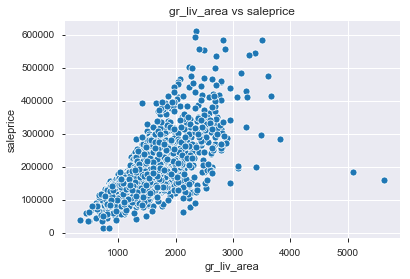

In [ ]:
# Scatterplot of Gr Liv Area Against Sales Price
sns.scatterplot(x = train_liv_area['gr_liv_area'], y = train_liv_area['saleprice'])
plt.title("gr_liv_area vs saleprice")

There are 2 outliers in the scatterplot, it will affect the regression so we should identify them and drop the rows.

In [ ]:
# Remove Houses with more than 4000 square feet
train = train[(train['gr_liv_area'] < 4000)]
train.head()

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,lot_shape,land_contour,utilities,...,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,misc_val,mo_sold,yr_sold,sale_type,saleprice
0,109,533352170,60,RL,NaN,13517,Pave,IR1,Lvl,AllPub,...,44,0,0,0,0,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,IR1,Lvl,AllPub,...,74,0,0,0,0,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,Reg,Lvl,AllPub,...,52,0,0,0,0,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,Reg,Lvl,AllPub,...,0,0,0,0,0,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,IR1,Lvl,AllPub,...,59,0,0,0,0,0,3,2010,WD,138500


<a id='checknull'></a>
### 2.4) Check Remaining Null Values

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2049 entries, 0 to 2050
Data columns (total 77 columns):
id                 2049 non-null int64
pid                2049 non-null object
ms_subclass        2049 non-null object
ms_zoning          2049 non-null object
lot_frontage       1719 non-null float64
lot_area           2049 non-null int64
street             2049 non-null object
lot_shape          2049 non-null object
land_contour       2049 non-null object
utilities          2049 non-null object
lot_config         2049 non-null object
land_slope         2049 non-null object
neighborhood       2049 non-null object
condition_1        2049 non-null object
condition_2        2049 non-null object
bldg_type          2049 non-null object
house_style        2049 non-null object
overall_qual       2049 non-null object
overall_cond       2049 non-null object
year_built         2049 non-null int64
year_remod/add     2049 non-null int64
roof_style         2049 non-null object
roof_matl       

<a id='splitter'></a>
#### Split into Catergorical and Continuous variables

In [ ]:
train_null_cat = train[['saleprice', 'mas_vnr_type', 'bsmt_qual', 'bsmt_cond', 'bsmt_exposure', 'bsmtfin_type_1', 'bsmtfin_type_2', 'fireplace_qu', 'garage_type', 'garage_finish', 'garage_qual', 'garage_cond']]
train_null_cont = train[['saleprice', 'mas_vnr_area', 'lot_frontage', 'garage_yr_blt']]

Text(0.5, 1.0, 'Heatmap for Continuous Null Variables')

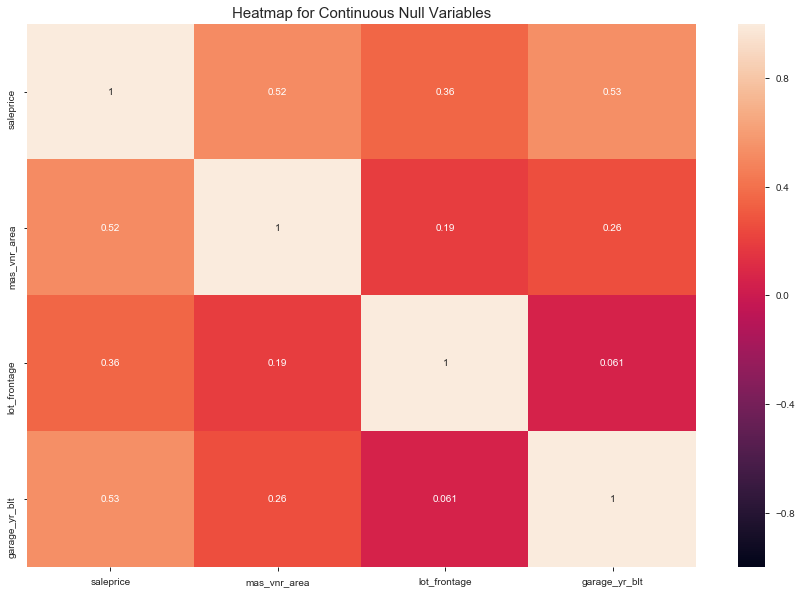

In [ ]:
# Plot heatmap Continuous variables to see correlation
heatmap(train_null_cont, (15,10))
plt.title('Heatmap for Continuous Null Variables', fontsize = 15)

Checking the Correlation of Variables before filling up Null Values

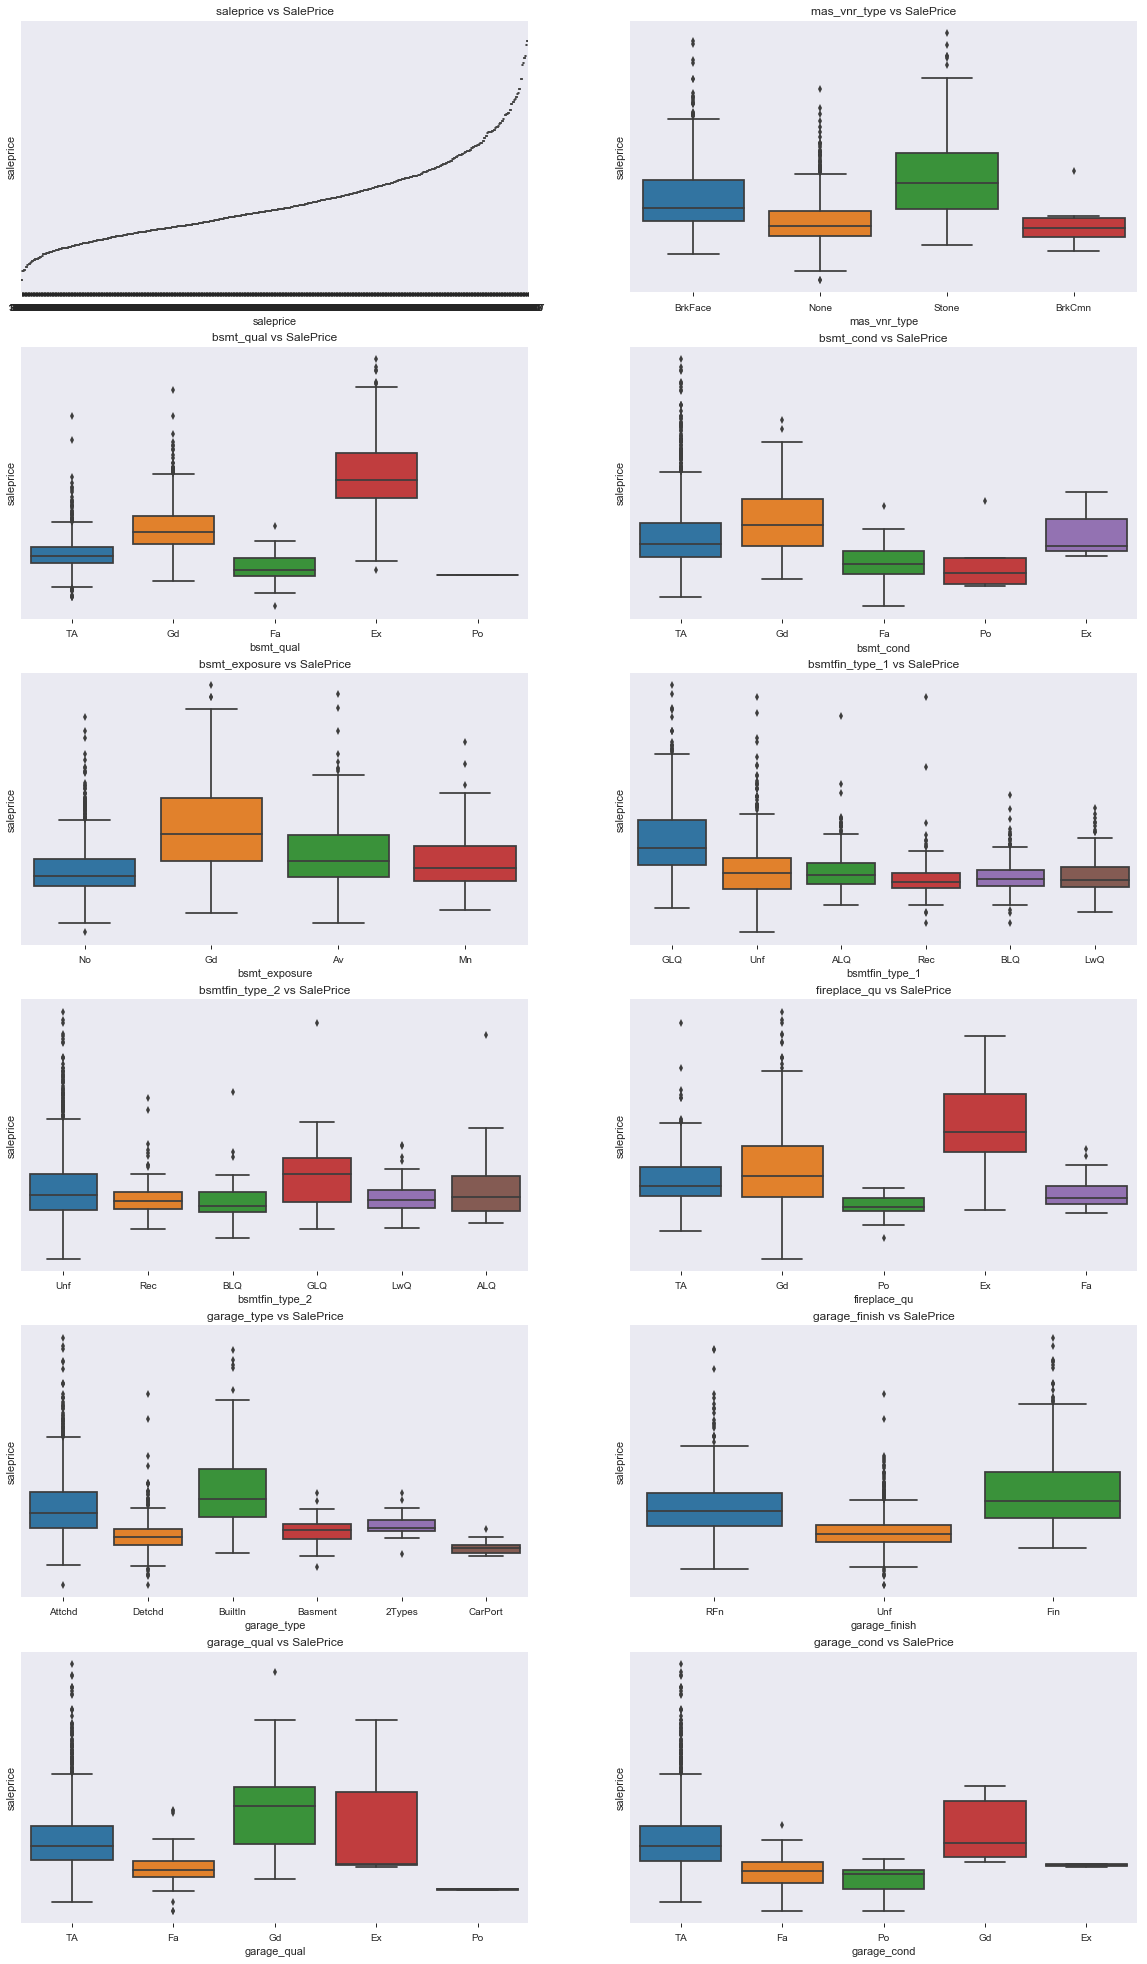

In [ ]:
# Plot BoxPlot for catergorical Variables
boxplot(train_null_cat,(20,35), 'saleprice')

Checking the relationship between categories before filling null values.


<a id='fillnull'></a>
### 2.5) Fill Null Values in Main Table

In [ ]:
# Fill Null Values of Mas Vnr Type
train['mas_vnr_type'].fillna("None", inplace=True)

In [ ]:
# Fill Null Values of all columns
fill_null(train, train.columns)
train.dtypes.value_counts()

object     42
int64      24
float64    11
dtype: int64

In [ ]:
# Reset index

train = train.reset_index(drop = True)
train.index


RangeIndex(start=0, stop=2049, step=1)

<a id='Split_dataframe'></a>
# 3) Split Dataframe ( We would be using these Dataframes to create our model from now)

<a id='splitcc'></a>
### 3.1) Split into Catergorical and Continuous Variable

In [ ]:
# Add SalePrice Column into both DataFrames
train_cont = train[['saleprice']]
train_cat = train[['saleprice']]

In [ ]:
# Split into Catergorical and Continuous Variable
for i in train.columns:
    if (i == 'saleprice'):
        print("saleprice Variable already added in the DataFrames")
    elif (train[i].dtype == 'object'):
        train_cat[i] = train[[i]]
    else:
        train_cont[i] = train[i]

saleprice Variable already added in the DataFrames


In [ ]:
# Categorical
train_cat.head()


,saleprice,pid,ms_subclass,ms_zoning,street,lot_shape,land_contour,utilities,lot_config,land_slope,...,electrical,kitchen_qual,functional,fireplace_qu,garage_type,garage_finish,garage_qual,garage_cond,paved_drive,sale_type
0,130500,533352170,60,RL,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,...,SBrkr,Gd,Typ,NA,Attchd,RFn,TA,TA,Y,WD
1,220000,531379050,60,RL,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,...,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,WD
2,109000,535304180,20,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,SBrkr,Gd,Typ,NA,Detchd,Unf,TA,TA,Y,WD
3,174000,916386060,60,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,SBrkr,TA,Typ,NA,BuiltIn,Fin,TA,TA,Y,WD
4,138500,906425045,50,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,SBrkr,TA,Typ,NA,Detchd,Unf,TA,TA,N,WD


In [ ]:
# Continuous
train_cont.head()

,saleprice,id,lot_frontage,lot_area,year_built,year_remod/add,mas_vnr_area,bsmtfin_sf_1,bsmtfin_sf_2,bsmt_unf_sf,...,garage_area,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,misc_val,mo_sold,yr_sold
0,130500,109,0.0,13517,1976,2005,289.0,533.0,0.0,192.0,...,475.0,0,44,0,0,0,0,0,3,2010
1,220000,544,43.0,11492,1996,1997,132.0,637.0,0.0,276.0,...,559.0,0,74,0,0,0,0,0,4,2009
2,109000,153,68.0,7922,1953,2007,0.0,731.0,0.0,326.0,...,246.0,0,52,0,0,0,0,0,1,2010
3,174000,318,73.0,9802,2006,2007,0.0,0.0,0.0,384.0,...,400.0,100,0,0,0,0,0,0,4,2010
4,138500,255,82.0,14235,1900,1993,0.0,0.0,0.0,676.0,...,484.0,0,59,0,0,0,0,0,3,2010


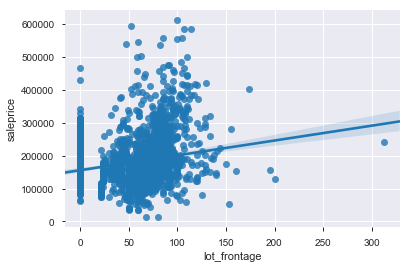

In [ ]:
# Checking Relationship between SalePrice and Lot Frontage
testing = train_cont[["saleprice",'lot_frontage']]
sns.regplot(data = testing, x="lot_frontage", y="saleprice")

In [ ]:
testing.corr()

,saleprice,lot_frontage
saleprice,1.000000,0.185351
lot_frontage,0.185351,1.000000


In [ ]:
# Drop Lot Frontage as there is little correlation and this column has multiple Null Values
train_cont = train_cont.drop(columns='lot_frontage')

<a id='splitdf'></a>
### 3.2) Split Catergorical into Ordinal and Nominal

In [ ]:
# (train_ord = ordinal), (train_nom = nominal)
train_ord = train[['saleprice','lot_shape','utilities','land_slope','overall_qual','overall_cond','exter_qual' , 'exter_cond','bsmt_qual','bsmt_cond','bsmt_exposure','bsmtfin_type_1','bsmtfin_type_2','electrical', 'functional','garage_finish', 'garage_qual', 'garage_cond', 'paved_drive','heating_qc','kitchen_qual','fireplace_qu']]
train_nom = train[['saleprice','pid', 'ms_subclass', 'ms_zoning', 'street', 'land_contour', 'lot_config' ,'neighborhood', 'condition_1' ,'condition_2' ,'bldg_type', 'house_style', 'roof_style', 'roof_matl', 'mas_vnr_type', 'foundation', 'heating','central_air', 'garage_type', 'sale_type', 'exterior_1st', 'exterior_2nd']]

In [ ]:
train_nom.head()

,saleprice,pid,ms_subclass,ms_zoning,street,land_contour,lot_config,neighborhood,condition_1,condition_2,...,roof_style,roof_matl,mas_vnr_type,foundation,heating,central_air,garage_type,sale_type,exterior_1st,exterior_2nd
0,130500,533352170,60,RL,Pave,Lvl,CulDSac,Sawyer,RRAe,Norm,...,Gable,CompShg,BrkFace,CBlock,GasA,Y,Attchd,WD,HdBoard,Plywood
1,220000,531379050,60,RL,Pave,Lvl,CulDSac,SawyerW,Norm,Norm,...,Gable,CompShg,BrkFace,PConc,GasA,Y,Attchd,WD,VinylSd,VinylSd
2,109000,535304180,20,RL,Pave,Lvl,Inside,NAmes,Norm,Norm,...,Gable,CompShg,None,CBlock,GasA,Y,Detchd,WD,VinylSd,VinylSd
3,174000,916386060,60,RL,Pave,Lvl,Inside,Timber,Norm,Norm,...,Gable,CompShg,None,PConc,GasA,Y,BuiltIn,WD,VinylSd,VinylSd
4,138500,906425045,50,RL,Pave,Lvl,Inside,SawyerW,Norm,Norm,...,Gable,CompShg,None,PConc,GasA,Y,Detchd,WD,Wd Sdng,Plywood


In [ ]:
train_nom.pid.value_counts()

907253130    1
908229020    1
903429110    1
923228260    1
907290040    1
909279080    1
528445060    1
534403400    1
535180070    1
527404180    1
535175070    1
527451400    1
528150080    1
528488120    1
909256120    1
527216050    1
527353020    1
533352150    1
535304020    1
528275110    1
905478140    1
528240070    1
528328100    1
535304100    1
531451110    1
535353240    1
905426100    1
916325080    1
535402140    1
910203250    1
            ..
905200220    1
535151110    1
909282060    1
903400180    1
906226140    1
902329080    1
534400060    1
902405120    1
535325400    1
907252050    1
533350120    1
907255060    1
532377130    1
905377050    1
909100170    1
528292020    1
528102030    1
528458090    1
908102300    1
535383100    1
903429010    1
527359080    1
528315030    1
905200490    1
535101120    1
909452102    1
531375100    1
904301070    1
902306130    1
527368020    1
Name: pid, Length: 2049, dtype: int64

Drop Column "pid" because there every row is a different PID so it is as good as being an index.

In [ ]:
train_nom = train_nom.drop( axis = 1, columns = train[['pid']])

In [ ]:
train_ord.head()

,saleprice,lot_shape,utilities,land_slope,overall_qual,overall_cond,exter_qual,exter_cond,bsmt_qual,bsmt_cond,...,bsmtfin_type_2,electrical,functional,garage_finish,garage_qual,garage_cond,paved_drive,heating_qc,kitchen_qual,fireplace_qu
0,130500,IR1,AllPub,Gtl,6,8,Gd,TA,TA,TA,...,Unf,SBrkr,Typ,RFn,TA,TA,Y,Ex,Gd,NA
1,220000,IR1,AllPub,Gtl,7,5,Gd,TA,Gd,TA,...,Unf,SBrkr,Typ,RFn,TA,TA,Y,Ex,Gd,TA
2,109000,Reg,AllPub,Gtl,5,7,TA,Gd,TA,TA,...,Unf,SBrkr,Typ,Unf,TA,TA,Y,TA,Gd,NA
3,174000,Reg,AllPub,Gtl,5,5,TA,TA,Gd,TA,...,Unf,SBrkr,Typ,Fin,TA,TA,Y,Gd,TA,NA
4,138500,IR1,AllPub,Gtl,6,8,TA,TA,Fa,Gd,...,Unf,SBrkr,Typ,Unf,TA,TA,N,TA,TA,NA


<a id='rankord'></a>
### 3.3) Rank Ordinal Variables / Drop any unusable columns in train_ord

#### 3.3.1) Label Encoder Method

In [ ]:
# Label Encoder Trial
# lb_make = LabelEncoder()
# train_ord['Exter_Qual'] = lb_make.fit_transform(train_ord['Exter Qual'])
# train_ord[["Exter Qual", 'Exter_Qual']].sort_values(by = 'Exter_Qual')

Using Label Encoder doesn't work. Number ranking given randomly

#### 3.3.2) Manual Method

In [ ]:
train_ord['utilities'].value_counts()

AllPub    2047
NoSeWa       1
NoSewr       1
Name: utilities, dtype: int64

Drop utilities because all values are the same, except 2 observations. Therefore, it does not tell us anything.

In [ ]:
train_ord.drop(columns='utilities', inplace = True, axis = 1)

In [ ]:
train_ord['land_slope'].value_counts()

Gtl    1951
Mod      88
Sev      10
Name: land_slope, dtype: int64

Drop land_slope because most category are the same, data is heavily skewed to Gtl. Therefore, it does not tell us anything about the price.

In [ ]:
train_ord.drop(columns='land_slope', inplace = True, axis = 1)

In [ ]:
train_ord['electrical'].value_counts()

SBrkr    1866
FuseA     140
FuseF      35
FuseP       7
Mix         1
Name: electrical, dtype: int64

Drop 'electrical' because most category are the same, data is heavily skewed to Sbrkr which is the highest quality. Therefore, it does not tell us anything about the price.

In [ ]:
train_ord.drop(columns='electrical', inplace = True, axis = 1)

In [ ]:
train_ord.columns

Index(['saleprice', 'lot_shape', 'overall_qual', 'overall_cond', 'exter_qual',
       'exter_cond', 'bsmt_qual', 'bsmt_cond', 'bsmt_exposure',
       'bsmtfin_type_1', 'bsmtfin_type_2', 'functional', 'garage_finish',
       'garage_qual', 'garage_cond', 'paved_drive', 'heating_qc',
       'kitchen_qual', 'fireplace_qu'],
      dtype='object')

In [ ]:
# Manual Method
# Create Dictionary for replacements

cleanup = {'lot_shape' : {'IR3':0,'IR2':1,'IR1':2,'Reg':3},
           'overall_qual': {'1': 0,'2':1,'3':2,'4':3,"5":4,"6":5,'7':6,'8':7,'9':8,'10':9},
           'overall_cond': {'1': 0,'2':1,'3':2,'4':3,"5":4,"6":5,'7':6,'8':7,'9':8},
           'exter_qual' : {'NA':0,"Po":1, 'Fa':2, 'TA': 3,'Gd': 4,"Ex":5},
           'exter_cond' : {'NA':0,"Po":1, 'Fa':2, 'TA': 3,'Gd': 4,"Ex":5},
           'bsmt_qual' : {'NA':0,"Po":1, 'Fa':2, 'TA': 3,'Gd': 4,"Ex":5},
           'bsmt_cond' : {'NA':0,"Po":1, 'Fa':2, 'TA': 3,'Gd': 4,"Ex":5},
           'bsmt_exposure' : {'NA':0,'No':1,'Mn':2,'Av':3,'Gd':4},
           'bsmtfin_type_1' : {'NA':0,"Unf":1,'LwQ':2,'Rec':3,'BLQ':4,"ALQ":5,'GLQ':6},
           'bsmtfin_type_2' : {'NA':0,"Unf":1,'LwQ':2,'Rec':3,'BLQ':4,"ALQ":5,'GLQ':6},
           'functional' : {'Sal':0,'Sev':1,'Maj2':2,'Maj1':3,'Mod':4,'Min2':5,'Min1':6,'Typ':7},
           'garage_finish' : {'NA':0, 'Unf':1, 'RFn':2,'Fin':3},
           'garage_qual' : {'NA':0,"Po":1, 'Fa':2, 'TA': 3,'Gd': 4,"Ex":5},
           'garage_cond' : {'NA':0,"Po":1, 'Fa':2, 'TA': 3,'Gd': 4,"Ex":5},
           'paved_drive' : {'N':0,'P':1,'Y':2},
           'heating_qc' : {'NA':0,"Po":1, 'Fa':2, 'TA': 3,'Gd': 4,"Ex":5},
           'kitchen_qual' : {'NA':0,"Po":1, 'Fa':2, 'TA': 3,'Gd': 4,"Ex":5},
           'fireplace_qu' : {'NA':0,"Po":1, 'Fa':2, 'TA': 3,'Gd': 4,"Ex":5}
           
}

In [ ]:
train_ord.replace(cleanup, inplace=True)

In [ ]:
train_ord.head()

,saleprice,lot_shape,overall_qual,overall_cond,exter_qual,exter_cond,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_type_2,functional,garage_finish,garage_qual,garage_cond,paved_drive,heating_qc,kitchen_qual,fireplace_qu
0,130500,2,5,7,4,3,3,3,1,6,1,7,2,3,3,2,5,4,0
1,220000,2,6,4,4,3,4,3,1,6,1,7,2,3,3,2,5,4,3
2,109000,3,4,6,3,4,3,3,1,6,1,7,1,3,3,2,3,4,0
3,174000,3,4,4,3,3,4,3,1,1,1,7,3,3,3,2,4,3,0
4,138500,2,5,7,3,3,2,4,1,1,1,7,1,3,3,0,3,3,0


<h1><center>Data Dictionary Ordinal DataFrame</center></h1>

|Feature|Type|Ranking Representation|
|---|---|---|
|lot_shape|Object|{'IR3':0,'IR2':1,'IR1':2,'Reg':3}|
|overall_qual|Object|{'1':0,'2':1,'3':2,'4':3,"5":4,"6":5,'7':6,'8':7,'9':8,'10':9}|
|overall_cond|Object|{'1':0,'2':1,'3':2,'4':3,"5":4,"6":5,'7':6,'8':7,'9':8}|
|exter_qual|Object|{'NA':0,"Po":1, 'Fa':2, 'TA': 3,'Gd': 4,"Ex":5}|
|exter_cond|Object|{'NA':0,"Po":1, 'Fa':2, 'TA': 3,'Gd': 4,"Ex":5}|
|bsmt_qual|Object|{'NA':0,"Po":1, 'Fa':2, 'TA': 3,'Gd': 4,"Ex":5}|
|bsmt_cond|Object|{'NA':0,"Po":1, 'Fa':2, 'TA': 3,'Gd': 4,"Ex":5}|
|bsmt_exposure|Object|{'NA':0,'No':1,'Mn':2,'Av':3,'Gd':4}|
|bsmtfin_type_1|Object|{'NA':0,"Unf":1,'LwQ':2,'Rec':3,'BLQ':4,"ALQ":5,'GLQ':6}|
|bsmtfin_type_2|Object|{'NA':0,"Unf":1,'LwQ':2,'Rec':3,'BLQ':4,"ALQ":5,'GLQ':6}|
|functional|Object|{'Sal':0,'Sev':1,'Maj2':2,'Maj1':3,'Mod':4,'Min2':5,'Min1':6,'Typ':7}|
|garage_finish|Object|{'NA':0, 'Unf':1, 'RFn':2,'Fin':3}|
|garage_qual|Object|{'NA':0,"Po":1, 'Fa':2, 'TA': 3,'Gd': 4,"Ex":5}|
|garage_cond|Object|{'NA':0,"Po":1, 'Fa':2, 'TA': 3,'Gd': 4,"Ex":5}|
|paved_drive|Object|{'N':0,'P':1,'Y':2}|
|heating_qc|Object|{'NA':0,"Po":1, 'Fa':2, 'TA': 3,'Gd': 4,"Ex":5}|
|kitchen_qual|Object|{'NA':0,"Po":1, 'Fa':2, 'TA': 3,'Gd': 4,"Ex":5}|
|fireplace_qu|Object|{'NA':0,"Po":1, 'Fa':2, 'TA': 3,'Gd': 4,"Ex":5}|

<a id='Model1'></a>
# Model 1

<a id='check__corr'></a>
# 4) Check for Correlation

In [ ]:
train_cont.head()

,saleprice,id,lot_area,year_built,year_remod/add,mas_vnr_area,bsmtfin_sf_1,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,...,garage_area,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,misc_val,mo_sold,yr_sold
0,130500,109,13517,1976,2005,289.0,533.0,0.0,192.0,725.0,...,475.0,0,44,0,0,0,0,0,3,2010
1,220000,544,11492,1996,1997,132.0,637.0,0.0,276.0,913.0,...,559.0,0,74,0,0,0,0,0,4,2009
2,109000,153,7922,1953,2007,0.0,731.0,0.0,326.0,1057.0,...,246.0,0,52,0,0,0,0,0,1,2010
3,174000,318,9802,2006,2007,0.0,0.0,0.0,384.0,384.0,...,400.0,100,0,0,0,0,0,0,4,2010
4,138500,255,14235,1900,1993,0.0,0.0,0.0,676.0,676.0,...,484.0,0,59,0,0,0,0,0,3,2010


In [ ]:
train_nom.head()

,saleprice,ms_subclass,ms_zoning,street,land_contour,lot_config,neighborhood,condition_1,condition_2,bldg_type,...,roof_style,roof_matl,mas_vnr_type,foundation,heating,central_air,garage_type,sale_type,exterior_1st,exterior_2nd
0,130500,60,RL,Pave,Lvl,CulDSac,Sawyer,RRAe,Norm,1Fam,...,Gable,CompShg,BrkFace,CBlock,GasA,Y,Attchd,WD,HdBoard,Plywood
1,220000,60,RL,Pave,Lvl,CulDSac,SawyerW,Norm,Norm,1Fam,...,Gable,CompShg,BrkFace,PConc,GasA,Y,Attchd,WD,VinylSd,VinylSd
2,109000,20,RL,Pave,Lvl,Inside,NAmes,Norm,Norm,1Fam,...,Gable,CompShg,None,CBlock,GasA,Y,Detchd,WD,VinylSd,VinylSd
3,174000,60,RL,Pave,Lvl,Inside,Timber,Norm,Norm,1Fam,...,Gable,CompShg,None,PConc,GasA,Y,BuiltIn,WD,VinylSd,VinylSd
4,138500,50,RL,Pave,Lvl,Inside,SawyerW,Norm,Norm,1Fam,...,Gable,CompShg,None,PConc,GasA,Y,Detchd,WD,Wd Sdng,Plywood


In [ ]:
train_ord.head()

,saleprice,lot_shape,overall_qual,overall_cond,exter_qual,exter_cond,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_type_2,functional,garage_finish,garage_qual,garage_cond,paved_drive,heating_qc,kitchen_qual,fireplace_qu
0,130500,2,5,7,4,3,3,3,1,6,1,7,2,3,3,2,5,4,0
1,220000,2,6,4,4,3,4,3,1,6,1,7,2,3,3,2,5,4,3
2,109000,3,4,6,3,4,3,3,1,6,1,7,1,3,3,2,3,4,0
3,174000,3,4,4,3,3,4,3,1,1,1,7,3,3,3,2,4,3,0
4,138500,2,5,7,3,3,2,4,1,1,1,7,1,3,3,0,3,3,0


<a id='check_corr'></a>
### 4.1) Check for Correlation between Price and Variables

In [ ]:
heatmap(train_cont,(30,20))
plt.title('Heatmap for Continuous Variables', fontsize = 30)

Text(0.5, 1.0, 'Heatmap for Continuous Variables')

There are too many variables in to see the correlation of each variable on the heatmap above.

Therefor, I would take the top 10 most correlated variables with price picked out using the correlation function to use in my model to predict housing prices.

In [ ]:
corr = train_cont.corr()
corr.sort_values(['saleprice'], ascending=False, inplace=True)
corr['saleprice'].head(11)

In [ ]:
heatmap(train_ord,(20,15))
plt.title('Heatmap for Ordinal Variables', fontsize = 20)

From the heatmap above, it looks like the top 10 variables correlated to saleprice is overall_qual, exter_qual, kitchen_qual, bsmt_qual, garage_finish, fireplace_qu, heating_qc, bsmt_exposure, bsmtfin_type_1, paved_drive.
To confirm, I used the correlation function to get the exact values. These variables would be used as predictors to predict housing price.

In [ ]:
corr_ord = train_ord.corr()
corr_ord.sort_values(["saleprice"], ascending=False, inplace= True)
corr_ord["saleprice"].head(11)

<a id='boxplot'></a>
### 4.2) Check Boxplot Between Price and Variables

In [ ]:
boxplot(train_nom, (25,70), 'saleprice')

ms_zoning: The median pricing of each category in MS zoning is significantly different from one another. Hence it can be inferred that each category has a different pricing range from one another and hence can be used in the model for pridicting price.


street: The median of Paved street is higher than median of Gravel street. This should that different street types affect the pricing of the house, hence it can be used in the model.


neighbourhood: The prices of houses in different neighbourhoods in the State varies with each state, therefore it can be used as a variable in the model.


condition_1: Different Proximities to various conditions seem to have effect on the prices of the houses. Hence it can be added into the model.


condition_2: : Different Proximities to various conditions seem to have effect on the prices of the houses. Hence it can be added into the model.


house_style: Different kind of houses seems to have different price ranges, Hence it can be added into the model.


roof_materials: Materials used on the roof seem to have a significant effect on the SalePrice. Therefore, it is added to the model.


heating: Different methods of heating in the house has a different price range as well based on the median of each type. Hence, it could be used to predict price.


central_air: Whether or not the house has a central air system seem to have an effect in price, hence it will be added to our model.


garage_type: Different types of garage has different price ranges. Hence it can be used as a variable as part of the model. However, the significance might not be as the price different is not very drastic.


sale_type: Some salestype results in different SalePrices. So, it could be added into our model. However, some of the different type result in the same price range.



In [ ]:
boxplot(train_ord, (25,70),'saleprice')

The boxplot complements the correlation function above in showing how the different ordinal variables affect the Salesprice. You can see the highly correlated ones have an obvious uptrend. Such as Overall Quality against price.

<a id='create_model'></a>
# 5) Create Model

<a id='drop'></a>
### 5.1) Determine which Column to drop

For this model, I have decided to take the top 10 variables with the highest correlation with Saleprice in each of the seperated DataFrames to use in my model to predict housing SalesPrice.

In [ ]:
# Nominal df

train_model_nom = train_nom[['saleprice','ms_zoning', "street", 'neighborhood','condition_1', 'condition_2', 'house_style', 'roof_matl', 'heating', "central_air", "garage_type", "sale_type"]]
train_model_nom = pd.get_dummies(train_model_nom, drop_first=True)
train_model_nom.head()

In [ ]:
# Ordinal df

train_model_ord = train_ord[corr_ord["saleprice"].iloc[0:11].index ]
train_model_ord.head()

In [ ]:
# Continous df

train_model_cont = train_cont[corr["saleprice"].iloc[0:11].index]
train_model_cont.head()

<a id='merge'></a>
### 5.2) Merge DataFrames to create Model

In [ ]:
# Merge 3 DataFrames together
train_1 = pd.concat([pd.concat([train_model_cont, train_model_ord.drop(columns = "saleprice")], axis=1),train_model_nom.drop(columns = "saleprice")], axis=1)
train_1.head()

<a id='corr'></a>
### 5.3) Check for correlation and pick 30 highest correlation

In [ ]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
corr_1 = train_1.corr()
corr_1.sort_values(["saleprice"], ascending=False, inplace= True)
corr_1['saleprice'].head(30)

In [ ]:
# Main model use to predict Housing Price
features_1 = corr_1["saleprice"].iloc[1:31].index 
train_model_1 = train_1[features_1 ]

In [ ]:
train_model_1.head()

<a id='model_prep'></a>
# 6) Prep Model


### 6.1) Model Prep: Create our features matrix (`X`) and target vector (`y`)

In [ ]:
X_1 = train_model_1
y_1 = train_1["saleprice"]


### 6.2) Model Prep: Train/test split

In [ ]:
# Creating the train/test split
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1,y_1,test_size=0.2, random_state = 42)


### 6.3) Model Prep: Normalize / PowerTransform Values

In [ ]:
ss = StandardScaler()
X_train_sc1 = ss.fit_transform(X_train_1)
X_test_sc1 = ss.transform(X_test_1)


### 6.4) Model Prep: Instantiate our models

In [ ]:
lr = LinearRegression()

In [ ]:
lasso = LassoCV(n_alphas=200)

In [ ]:
ridge = RidgeCV(alphas = np.linspace(.1,10,100))

<a id='test1'></a>
# 7) Test Model


### 7.1) Cross validation

In [ ]:
lr_score_1 = cross_val_score(lr,X_train_sc1,y_train_1,cv=10)
lr_score_1.mean()

In [ ]:
ridge_score_1 = cross_val_score(ridge, X_train_sc1, y_train_1, cv=10)
ridge_score_1.mean()

In [ ]:
lasso_score_1 = cross_val_score(lasso, X_train_sc1, y_train_1, cv=10)
lasso_score_1.mean()

Using the 3 models, it would seem that lassoCV is doing the best, although only slightly better than the linearRegression model. Hence, we will carry on with that model to fit to the training data and evaluate training and test scores.


### 7.2) Model Fitting and Evaluation

In [ ]:
# Fitting the model to training data
lasso.fit(X_train_sc1, y_train_1)

In [ ]:
# Training Data Score
lasso.score(X_train_sc1, y_train_1)

In [ ]:
# Testing Data Score
lasso.score(X_test_sc1, y_test_1)

From the scores of my training scores and my test scores, the training scores are slightly higher than test scores, this shows there is a very slight overfitting and I should identify some columns to drop.

In [ ]:
# Barplot to see how each coefficient of the variables relate to the SalesPrice
pd.Series(lasso.coef_, index=features_1).plot.bar(figsize=(15, 7))
plt.title('Coefficients of Predictors')

<a id='multicollinearity1'></a>
### 7.3) Check for Multicollinearity

A common rule of thumb is that multicollinearity may be a problem in a data set if any pairwise |r| > 0.7

In [ ]:
multicollinearity(X_1)

From the Barplot above, we can see that some of the coefficients of some variables used in the model are very low and close to negligible. I can refine my model by removing some of the variables with very low coefficients as i means that those variables would not affect the model much. 

Also, Based on multicollinearity, drop 1 of the column pair is correlation > 0.7

Variables to drop are: 
- garage_cars
- totrms_abvgrd
- 1st_flr_sf
- exter_qual
- garage_type_Attchd
- paved_drive
- central_air_Y
- house_style_2Story

<a id='refine1'></a>
# 8) Refine Model

In [ ]:
# Drop columns to create Final Model 1
train_model_1_fin = train_model_1.drop(columns=['garage_cars','totrms_abvgrd','1st_flr_sf','exter_qual','garage_type_Attchd','paved_drive','central_air_Y','house_style_2Story'])

In [ ]:
# Create our features matrix (`X`) and target vector (`y`)
X_1_fin = train_model_1_fin
y_1_fin = train_1["saleprice"]

In [ ]:
# Creating the train/test split
X_train_1_fin, X_test_1_fin, y_train_1_fin, y_test_1_fin = train_test_split(X_1_fin,y_1_fin,test_size=0.2, random_state = 42)

In [ ]:
# Normalize / PowerTransform Values
X_train_sc1_fin = ss.fit_transform(X_train_1_fin)
X_test_sc1_fin = ss.transform(X_test_1_fin)

In [ ]:
# Cross validation
lasso_score_1_fin = cross_val_score(lasso, X_train_sc1_fin, y_train_1_fin, cv=10)
print("Lasso Regression Score :" + str(lasso_score_1_fin.mean()))
lr_score_1_fin = cross_val_score(lr,X_train_sc1_fin,y_train_1_fin,cv=10)
print("Linear Regression Score :" + str(lr_score_1_fin.mean()))
ridge_score_1_fin = cross_val_score(ridge, X_train_sc1_fin, y_train_1_fin, cv=10)
print("Ridge Regression Score :" + str(ridge_score_1_fin.mean()))


Ridge Regression Score Performs the best so I shall use the Ridge Regression to fit to the training data and evaluate training and test scores.

In [ ]:
# Fitting the model to training data
ridge.fit(X_train_sc1_fin, y_train_1_fin)

In [ ]:
# Training Data Score
ridge.score(X_train_sc1_fin, y_train_1_fin)

In [ ]:
# Testing Data Score
ridge.score(X_test_sc1_fin, y_test_1_fin)

Test Score and Training Score is about the same after refining. Model is no longer overfitted.

In [ ]:
# Calculating the Predicted Price using X_test_sc1_fin
pred_1 = ridge.predict(X_test_sc1_fin)

In [ ]:
residuals_1 = y_test_1_fin - pred_1

In [ ]:
sns.regplot(pred_1,residuals_1)

Scatterplot show an even spread of between predicted and residuals except for a few outliers.

In [ ]:
# RMSE of the model
rmse_1 = np.sqrt(mean_squared_error(y_test_1_fin, pred_1))
rmse_1

<a id='model2'></a>
# Model 2

<a id='merge2'></a>
### Merge DataFrames (Cont / Ord / Nom)

In [ ]:
train_nom_2 = pd.get_dummies(train_nom, drop_first=True)
train_nom_2.head()

In [ ]:
train_ord.head()

In [ ]:
train_cont.head()

In [ ]:
# Merging DataFrames
train_2 = pd.concat([pd.concat([train_cont,train_ord.drop(columns = "saleprice")],axis=1),train_nom_2.drop(columns = "saleprice")],axis = 1)
train_2

<a id='lasso'></a>
### Using LassoCV to remove unneccessary Variables

Lasso deals primarily with the feature selection of valuable variables, eliminating ones that are not useful. 

This also takes care of multicollinearity,but in a different way: it will choose the "best" of the correlated variables and zero-out the other redundant ones.

There may also be useless variables in the data which it is simply getting rid of entirely.

Hence, for this model, we will use this method to get the best variables.

In [ ]:
features = train_2.drop(columns = "saleprice").columns
X = train_2.drop(columns = "saleprice")
y = train_2["saleprice"]

In [ ]:
# Scale X
X_sc = ss.fit_transform(X)

In [ ]:
lasso.fit(X_sc,y)

In [ ]:
lasso_coefs = pd.DataFrame({'variable':X.columns,
                            'coef':lasso.coef_,
                            'abs_coef':np.abs(lasso.coef_)})

lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)
lasso_coefs.head(25)

From this table of coefficients, to create my model, i will take the variables with the highest absolute cofficients as those are the variables that will affect price change the most. 

**Why do I take the absolute instead of the normal coefficients?**

It is beacause, I want to find out which variables causes the price of the house to increase, and i also want to find out which variables would cause prices to fall as well so as to better be able to predict how prices fluctuate.

<a id='model_prep2'></a>
### Create Model

In [ ]:
features_2 = lasso_coefs["variable"].iloc[:26]


### Model Prep: Create our features matrix (`X`) and target vector (`y`)

In [ ]:
X_2 = train_2[features_2]
y_2 = train_2["saleprice"]

<a id='multicollinearity2'></a>
### Check for Multicollinearity

A common rule of thumb is that multicollinearity may be a problem in a data set if any pairwise |r| > 0.7

In [ ]:
multicollinearity(X_2)

Drop Exter Qual as Multicollinearity affects both Overall Qual and Kitchen Qual

In [ ]:
# Drop Columns
X_2 = X_2.drop(columns=['exter_qual'])
features_2 = X_2.columns

In [ ]:
X_2.shape


### Model Prep: Train/test split

In [ ]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.2, random_state = 42)


### Model Prep: Normalize / PowerTransform Values

In [ ]:
X_train_sc2 = ss.fit_transform(X_train_2)
X_test_sc2 = ss.transform(X_test_2)

<a id='test2'></a>
## Test Model


### Cross validation

In [ ]:
lasso_score_2 = cross_val_score(lasso, X_train_sc2, y_train_2, cv=10)
print("Lasso Regression Score :" + str(lasso_score_2.mean()))
lr_score_2 = cross_val_score(lr,X_train_sc2,y_train_2,cv=10)
print("Linear Regression Score :" + str(lr_score_2.mean()))
ridge_score_2 = cross_val_score(ridge, X_train_sc2, y_train_2, cv=10)
print("Ridge Regression Score :" + str(ridge_score_2.mean()))

Ridge Regression has the best score. Therefore, I would be using the ridge regression to fit my model and evaluate it.


### Model Fitting and Evaluation

In [ ]:
# Fitting the training data into Ridge Regression Model
ridge2 = ridge.fit(X_train_sc2, y_train_2)

In [ ]:
# Score of the Training Data
ridge.score(X_train_sc2,y_train_2)

In [ ]:
# Score of the Test Data
ridge.score(X_test_sc2, y_test_2)

The Score of the training data is around the same as the score of the test data. This shows there is no signs of overfitting.

In [ ]:
# Calculating predicted price
pred_2 = ridge.predict(X_test_sc2)

In [ ]:
residuals_2 = y_test_2 - pred_2

In [ ]:
# Plotting a graph of residuals against prediction
sns.regplot(pred_2,residuals_2)

Scatterplot shows random distribution of plot except for 1 outlier. Model is good.

In [ ]:
# RMSE of the model
rmse_2 = np.sqrt(mean_squared_error(y_test_2, pred_2))
rmse_2

<a id='model_3'></a>
# Model 3

<a id='merge3'></a>
### Merge DataFrames

In [ ]:
train_3 = pd.concat([pd.concat([train_cont,train_ord.drop(columns = "saleprice")],axis=1),train_nom.drop(columns = "saleprice")],axis = 1)
train_3.head()

<a id='feature_eng'></a>
### Feature Engineering


Combine columns that are Linked / Similar to each other and add into DataFrame

In [ ]:
# Combine Overall Qual and Overall Cond
train_3['comb_overall'] = train_3['overall_qual'] * train_3['overall_cond']
# Combine Exter Qual and Exter Cond
train_3['exter_overall'] = train_3['exter_qual'] * train_3['exter_cond']
# Combine Bsmt Qual and Bsmt Cond
train_3['bsmt_overall'] = train_3['bsmt_qual'] * train_3['bsmt_cond']
# Combine Full Bath and Half Bath
train_3['total_bath'] = train_3['bsmt_full_bath'] + train_3['full_bath'] + (0.5*(train_3['bsmt_half_bath']  + train_3['half_bath']))
# Combine Kitchen and Kitchen Quality
train_3['kitchen_overall'] = train_3['kitchen_abvgr'] * train_3['kitchen_qual']
# Combine Fireplace
train_3['fireplace_overall'] = train_3['fireplaces'] * train_3['fireplace_qu']
# Garage Overall
train_3['garage_overall'] = train_3['garage_qual'] * train_3['garage_cond']
# Combine all the SF
train_3['total_sf'] = train_3['total_bsmt_sf'] + train_3['gr_liv_area'] + train_3["garage_area"]

In [ ]:
train_3.shape

Drop Columns that have been combined because the combined columns would have extremely high correlation with the columns that created it. To avoid this situation. We drop the columns that were used.

In [ ]:
train_3 = train_3.drop(columns=['overall_qual','overall_cond','exter_qual','exter_cond','bsmt_qual','bsmt_cond','bsmt_full_bath','full_bath','bsmt_half_bath','half_bath', 'kitchen_abvgr', 'kitchen_qual', 'fireplaces', 'fireplace_qu', 'garage_qual', 'garage_cond', 'total_bsmt_sf', 'gr_liv_area', 'garage_area'])

In [ ]:
train_3 = pd.get_dummies(train_3)

In [ ]:
corr_3 = train_3.corr()
corr_3.sort_values(["saleprice"], ascending=False, inplace= True)
corr_3['saleprice'].head(28)

<a id='create_xy3'></a>
### Create our features matrix (`X`) and target vector (`y`)

In [ ]:
features_3 = corr_3["saleprice"].iloc[1:28].index 

In [ ]:
X_3 = train_3[features_3]
y_3 = train_3["saleprice"]

<a id='multicollinearity3'></a>
### Check for Multicollinearity

A common rule of thumb is that multicollinearity may be a problem in a data set if any pairwise |r| > 0.7a

In [ ]:
multicollinearity(X_3)

Drop Columns : 1st Flr SF, BsmtFin Type 1, Exterior 2nd_VinylSd because their correlation to SalePrice is lower than their counterpart.

In [ ]:
# Drop Columns
X_3 = X_3.drop(columns=['1st_flr_sf', 'bsmtfin_type_1', 'exterior_2nd_VinylSd'])

<a id='Model_prep3'></a>
### Model Prep: Train/test split

In [ ]:
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_3, y_3, test_size=0.2, random_state = 42)

### Model Prep: Normalize / PowerTransform Values

In [ ]:
X_train_sc3 = ss.fit_transform(X_train_3)
X_test_sc3 = ss.transform(X_test_3)

<a id='test3'></a>
## Test Model


### Cross validation

In [ ]:
lasso_score_3 = cross_val_score(lasso, X_train_sc3, y_train_3, cv=10)
print("Lasso Regression Score :" + str(lasso_score_3.mean()))
lr_score_3 = cross_val_score(lr,X_train_sc3,y_train_3,cv=10)
print("Linear Regression Score :" + str(lr_score_3.mean()))
ridge_score_3 = cross_val_score(ridge, X_train_sc3, y_train_3, cv=10)
print("Ridge Regression Score :" + str(ridge_score_3.mean()))

Lasso Regression has the best score. Therefore, I would be using the Lasso regression to fit my model and evaluate it.


### Model Fitting and Evaluation

In [ ]:
# Fitting the training data into lasso Regression Model
lasso.fit(X_train_sc3, y_train_3)

In [ ]:
# Score of the Training Data
lasso.score(X_train_sc3,y_train_3)

In [ ]:
# Score of the Test Data
lasso.score(X_test_sc3, y_test_3)

The Score of the training data is slightly higher than the score of the test data. This shows there is no signs of overfitting.

In [ ]:
# Calculating predicted price
pred_3 = lasso.predict(X_test_sc3)

In [ ]:
residuals_3 = y_test_3 - pred_3

In [ ]:
# Plotting a graph of residuals against prediction
sns.regplot(pred_3,residuals_3)

Scatterplot shows random distribution of plot except for 1 outlier. Model is good.

In [ ]:
# RMSE of the model
rmse_2 = np.sqrt(mean_squared_error(y_test_3, pred_3))
rmse_2

<a id='Kaggle'></a>
# 9) Test Model on Kaggle Test Data

In [ ]:
# Load Kaggle Dataset
kaggle_test = pd.read_csv("../datasets/test.csv", dtype={'MS SubClass': object, "PID": object, "Overall Qual": object, "Overall Cond": object})
kaggle_test.columns

To have similar columns as my models, I have to drop some unused columns first.

Columns to drop : 'Misc Feature', 'Fence', 'Pool QC', 'Alley', 'Lot Frontage', "PID", 'Utilities', 'Land Slope', 'Electrical'

In [ ]:
# Clean Kaggle Dataset
kaggle_test = kaggle_test.drop(columns = ['Misc Feature','Fence', 'Pool QC', 'Alley', 'Lot Frontage', "PID", 'Utilities', 'Land Slope', 'Electrical'], axis = 1)
kaggle_test['Mas Vnr Type'].fillna("None", inplace=True)

In [ ]:
# Fill Null Values
fill_null(kaggle_test, kaggle_test.columns)

In [ ]:
# Rename Columns
kaggle_test = kaggle_test.rename(columns = lambda x : rename(x))

In [ ]:
# Rank all Ordinal Variables
kaggle_test.replace(cleanup, inplace=True)


In [ ]:
# Change Nominal Data to get_dummies
kaggle_test_dum = pd.get_dummies(kaggle_test)

<a id='Kaggle_1'></a>
## 9.1) Predict Kaggle Data with Model 1

Model 1 Training data : X_1_fin

Model 1 Training data : y_1_fin

In [ ]:
# Create Similar Columns with Kaggle Test Data
kaggle_test_1 = kaggle_test_dum[X_1_fin.columns]
kaggle_test_1.head()

In [ ]:
# Fit Model 1 into Ridge Regression
X_train_sc1_fin = ss.fit_transform(X_train_1_fin)
ridge.fit(X_train_sc1_fin, y_train_1_fin)

In [ ]:
# Scale Kaggle Model 1 based on scalling of Model 1
kaggle_test_1sc = ss.transform(kaggle_test_1)

In [ ]:
# Predict Kaggle SalePrice
pred_kaggle_1 = ridge.predict(kaggle_test_1sc)

In [ ]:
# Create DataFrame with ID and SalePrice
prediction_1 = kaggle_test[["id"]]
prediction_1["SalePrice"] = pred_kaggle_1
prediction_1.rename(columns={'id':'Id'}, inplace=True)
prediction_1.set_index('Id', inplace= True)

In [ ]:
# Save Dataset to CSV to submit to Kaggle
prediction_1.to_csv("./prediction_1.csv")

### Kaggle Score for Model 1: RMSE = 31730.63840 (Public) , 33019.52792 (Private) 

<a id='Kaggle_2'></a>
## 9.2) Predict Kaggle Data with Model 2

Model 2 Training data : X_2

Model 2 Training data : y_2

In [ ]:
kaggle_test_dum['neighborhood_GrnHill'] = 0

In [ ]:
# Create Similar Columns with Kaggle Test Data
kaggle_test_2 = kaggle_test_dum[X_2.columns]
kaggle_test_2.shape

In [ ]:
# Fit Model 2 into Ridge Regression
X_train_sc2 = ss.fit_transform(X_train_2)
ridge.fit(X_train_sc2, y_train_2)

In [ ]:
# Scale Kaggle Model 2 based on scalling of Model 2
kaggle_test_2sc = ss.transform(kaggle_test_2)

In [ ]:
# Predict Kaggle SalePrice
pred_kaggle_2 = ridge.predict(kaggle_test_2sc)

In [ ]:
# Create DataFrame with ID and SalePrice
prediction_2 = kaggle_test[["id"]]
prediction_2["saleprice"] = pred_kaggle_2
prediction_2.rename(columns={'id':'Id'}, inplace=True)
prediction_2.set_index('Id', inplace= True)

In [ ]:
# Save Dataset to CSV to submit to Kaggle
prediction_2.to_csv("./prediction_2.csv")

### Kaggle Score for Model 2: RMSE = 28669.97609 (Public) , 31707.44886 (Private)

<a id='Kaggle_3'></a>
## 9.3) Predict Kaggle Data with Model 3

Model 3 Training data : X_3

Model 3 Training data : y_3

<a id='modify_kaggle_3'></a>
### 9.3.1) Modify Kaggle Data to be similar as Training Data

In [ ]:
# Combine Overall Qual and Overall Cond
kaggle_test['comb_overall'] = kaggle_test['overall_qual'] * kaggle_test['overall_cond']
# Combine Exter Qual and Exter Cond
kaggle_test['exter_overall'] = kaggle_test['exter_qual'] * kaggle_test['exter_cond']
# Combine Bsmt Qual and Bsmt Cond
kaggle_test['bsmt_overall'] = kaggle_test['bsmt_qual'] * kaggle_test['bsmt_cond']
# Combine Full Bath and Half Bath
kaggle_test['total_bath'] = kaggle_test['bsmt_full_bath'] + kaggle_test['full_bath'] + (0.5*(kaggle_test['bsmt_half_bath']  + kaggle_test['half_bath']))
# Combine Kitchen and Kitchen Quality
kaggle_test['kitchen_overall'] = kaggle_test['kitchen_abvgr'] * kaggle_test['kitchen_qual']
# Combine Fireplace
kaggle_test['fireplace_overall'] = kaggle_test['fireplaces'] * kaggle_test['fireplace_qu']
# Garage Overall
kaggle_test['garage_overall'] = kaggle_test['garage_qual'] * kaggle_test['garage_cond']
# Combine all the SF
kaggle_test['total_sf'] = kaggle_test['total_bsmt_sf'] + kaggle_test['gr_liv_area'] + kaggle_test["garage_area"]

In [ ]:
# Change Datatype to correct datatype
kaggle_test['bsmt_overall'] = kaggle_test['bsmt_overall'].astype(int)

In [ ]:
# Create Similar Columns with Kaggle Test Data
kaggle_test_dum3 = pd.get_dummies(kaggle_test)
kaggle_test_3 = kaggle_test_dum3[X_3.columns]
kaggle_test_3.shape

<a id='predict_kaggle_3'></a>
### 9.3.2) Predict Kaggle Data

In [ ]:
# Fit Model 2 into Ridge Regression
X_train_sc3 = ss.fit_transform(X_train_3)
lasso.fit(X_train_sc3, y_train_3)

In [ ]:
# Scale Kaggle Model 2 based on scalling of Model 2
kaggle_test_3sc = ss.transform(kaggle_test_3)

In [ ]:
# Predict Kaggle SalePrice
pred_kaggle_3 = lasso.predict(kaggle_test_3sc)

In [ ]:
# Create DataFrame with ID and SalePrice
prediction_3 = kaggle_test[["id"]]
prediction_3["SalePrice"] = pred_kaggle_3
prediction_3.rename(columns={'id':'Id'}, inplace=True)
prediction_3.set_index('Id', inplace= True)

In [ ]:
# Save Dataset to CSV to submit to Kaggle
prediction_3.to_csv("./prediction_3.csv")

### Kaggle Score for Model 3: RMSE = 33611.97639 (Public) , 33342.21643 (Private)

<a id='Recommendations'></a>
# 10) Recommendations

### Best Model = Model 2 (Recommendations will be based on Model 2)

In [ ]:
# Create DataFrame with y_test_2 and pred_2
model2_line = pd.DataFrame(columns = ["test_saleprice"])
model2_line['test_saleprice'] = y_test_2
model2_line['pred_saleprice'] = pred_2
model2_line.sort_index(inplace=True)

In [ ]:
# Plot a lineplot between test data saleprice against predicted saleprice
plt.figure(figsize=(45,15))
plt.plot(model2_line.index, 'test_saleprice', data = model2_line, marker='o', color='skyblue')
plt.plot(model2_line.index, 'pred_saleprice', data = model2_line, marker='D', color='olive')
plt.title(label = "Comparison Between Test SalePrice and Predicted SalePrice", fontsize = 35,)
plt.legend(prop={'size':30})
plt.xticks(fontsize = 35)
plt.yticks(fontsize = 35)
plt.xlabel("ID", fontsize = 35)
plt.ylabel("SalePrice", fontsize = 35)

The blue line in the graph represents the Saleprice for the test data, the green line represents the Saleprice for the predicted values.

From the graph, I can confidently say that this model can predict house prices in Aimes/Iowa pretty well. As you can see, for each ID, which represents a house, the test point and predicted point is quite close to one another, which means the prices do not vary much and can be used to model prices for people who is looking to buy or sell their house. 

Do note that the predicted prices should be used just as a benchmark. Actual price will still be determined by the owners of the house.

**1) Which features appear to add the most value to a home?**

In [ ]:
# Barplot to see how each coefficient of the variables relate to the SalesPrice
pd.Series(ridge2.coef_, index=features_2).plot.bar(figsize=(15, 7))
plt.title('Coefficients of Predictors')

From the Barplot above, the top 3 features that adds the most value to home prices is General Living Area, which is the Square Feet of your living space, the Overall Quality of your house and also at which year the house was built.
So basically the main biggest factors that affect housing price is the size of your house and how old and well maintained is the house.

**2) Which features hurt the value of a home the most?**

The Features that hurts the value of your home the most based on the data is the number of bedrooms you have in your house, which is a little strange. The 2nd feature that hurts the value is if the house is the end units of a twinhouse.

**3) What are things that homeowners could improve in their homes to increase the value?**

Other than having a bigger house. A homeowner can increase their home value by keeping the Quality and Condition of their house at tip top shape. The few biggest correlations with price other than the squarefeet of the house is Overall Quality, Overall Condition and Kitchen Quality. 

The other features cannot be changed.

**4) What neighborhoods seem like they might be a good investment?**

From the graph above, the best neighborhoods to invest in right now which has the highest coefficient are, Northridge Heights, Stone Brook, Northridge and Green Hills respectively from ranking from the best neighborhood.

**5) Do you feel that this model will generalize to other cities? How could you revise your model to make it more universal OR what data would you need from another city to make a comparable model?**

I think the model would not work very well in other cities because the data used to train the model is focused on just this city. In order to make the model more universal, i would need data on the sale prices, city, sizes of the houses and the quality of the houses at least. As, those data are the more critical variables to predict housing price.